# Red de empresas
__Queletzu y Mariana__

Existen dos tipos de empresas:

* Las “puede con todas” que tienen contratos con muchas dependencias por “licitación abierta”. Las “puede con todas” son expertas en licitaciones, pueden facturar muchos contratos de gran monto.
* Las “favoritas” que tienen contratos con menos de tres dependencias por “adjudicación directa” o “invitación a tres” Las “favoritas” pueden facturar relativamente poco dinero (menos de 10 millones) pero son sospechosas de tráfico de influencias con una entidad en particular

¿Cómo las encontramos?


## Indice

1. Construir red a partir de csv
2. Calcular distribuciones de la red


In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import re
from unidecode import unidecode

import matplotlib.pyplot as plt
import matplotlib_venn
import seaborn as sns

def clean_string(s):
    if type(s)==str:
        s = s.split(';')[0]
        s = s.strip().title()
        s = unidecode(s)
        s = re.sub('[^A-Za-z0-9 ]+', '', s)
    return s

## 1. Construir red a partir de csv

Podemos ver la base de datos como una red con dos tipos de nodos: empresa / unidad compradora 

Necesitamos
* Empresa
* Unidad compradora
* Dependencia
* Tipo adjudicación
* Monto
* Servicio

Esta red tiene dos tipos de interacciones con varios atributos
* empresa
* dueño
* dependencia
* unidad
* c_num (número de contratos entre la empresa y unidad)
* c_dir (número de contratos por adjudicación directa)
* c_inv (número de contratos por invitación a tres)
* c_lic (número de contratos por licitación abierta)
* c_ids (lista de IDs de todos los contratos)
* m_tot (suma del importe de todos los contratos)
* m_dir (suma del importe contratos por adjudicación directa)
* m_inv (suma del importe contratos por invitación a tres)
* m_lic (suma del importe contratos por licitación abierta)
* p_dir (porcentaje del monto por adjudicación directa)
* p_inv (porcentaje del monto por invitación a tres)
* p_lic (porcentaje del monto por licitación abierta)


Cargar y limpiar datos

In [2]:
df = pd.read_csv('data-raw/2018.csv')
print(df.shape)
print(df.columns)
print(df.dtypes)

df = df[['dependencia', 'uc' ,'empresa', 'method', 'monto', 'servicio']]
df.columns = ['institucion', 'unidad', 'empresa', 'tipo', 'monto', 'servicio']

df['monto'] = df['monto'] / 1000000
for i in ['direct', 'open', 'limited']:
    df[i] = df['tipo'].apply(lambda x: 1 if x==i else 0)
    df[i] = df[i] * df['monto']
    df[i] = df[i].replace(0, np.nan)
for i in ['institucion', 'unidad', 'empresa']: 
    df[i] = df[i].apply(clean_string)

df.tail()

(180016, 6)
Index(['empresa', 'uc', 'dependencia', 'method', 'monto', 'servicio'], dtype='object')
empresa         object
uc              object
dependencia     object
method          object
monto          float64
servicio        object
dtype: object


,institucion,unidad,empresa,tipo,monto,servicio,direct,open,limited
180011,Exportadora De Sal SA De CV,Gerencia De Adquisiciones Y Almacenes,Equipos Y Soldaduras Del Norte Sa De Cv,direct,0.140386,Adquisiciones,0.140386,NaN,NaN
180012,Exportadora De Sal SA De CV,Gerencia De Adquisiciones Y Almacenes,Equipos Y Soldaduras Del Norte Sa De Cv,direct,0.245974,Adquisiciones,0.245974,NaN,NaN
180013,Exportadora De Sal SA De CV,Gerencia De Adquisiciones Y Almacenes,Castro Vega Arturo Jesus,direct,0.066000,Adquisiciones,0.066000,NaN,NaN
180014,Exportadora De Sal SA De CV,Gerencia De Adquisiciones Y Almacenes,Lopez Montoya Baldomero Joel,direct,0.105000,Servicios,0.105000,NaN,NaN
180015,Exportadora De Sal SA De CV,Gerencia De Adquisiciones Y Almacenes,Lopez Leon Arturo,direct,0.073665,Servicios,0.073665,NaN,NaN


Filtrar

Calcular tabla interacciones

In [3]:
red = df.groupby(['institucion','empresa']).aggregate({
                  'monto':  {'c_num':'count', 'm_tot':'sum'},
                  'direct': {'c_dir':'count', 'm_dir':'sum', 'p_dir':'sum'},
                  'limited':{'c_inv':'count', 'm_inv':'sum', 'p_inv':'sum'},
                  'open':   {'c_lic':'count', 'm_lic':'sum', 'p_lic':'sum'},
                  })
red.columns = red.columns.droplevel()
red = red.reset_index().sort_values(['m_inv','c_num'], ascending=False)
red[['p_dir', 'p_inv', 'p_lic']] = red[['p_dir', 'p_inv', 'p_lic']].divide(red['m_tot'], axis=0)
red.head()

/home/esther/.local/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,institucion,empresa,c_num,m_tot,c_dir,m_dir,p_dir,c_inv,m_inv,p_inv,c_lic,m_lic,p_lic
76113,SlpPresidencia Municipal De Tampamolon Corona,Construcciones E Inmobiliarias Canaro Sa De Cv,4,1711.992755,0,0.000000,0.000000,4,1711.992755,1.000000,0,0.0,0.0
30839,Instituto De Seguridad Y Servicios Sociales De...,Edenred Mexico Sa De Cv,1,1415.089298,0,0.000000,0.000000,1,1415.089298,1.000000,0,0.0,0.0
43413,Instituto Nacional De Ciencias Medicas Y Nutri...,Corporacion De Implementos Industriales Sa De Cv,1,1323.363162,0,0.000000,0.000000,1,1323.363162,1.000000,0,0.0,0.0
7458,CdmxSecretaria De Obras Y Servicios,Grupo Borsen Sa De Cv,2,996.361248,1,8.748683,0.008781,1,987.612565,0.991219,0,0.0,0.0
69111,Secretaria De La Defensa Nacional,Comercializadora Lini S A De C V,1,772.734383,0,0.000000,0.000000,1,772.734383,1.000000,0,0.0,0.0


Descripción red

In [4]:
empresas = red.groupby("empresa").aggregate({'institucion':{'count':'count'}, 'c_num':{'c_num':'sum'},
                                             'm_tot':{'sum':'sum', 'mean':'mean', 'max':'max', 'min':'min', 'std':'std'},
                                             'm_dir':{'m_dir':'sum','p_dir':'sum'},
                                             'm_inv':{'m_inv':'sum','p_inv':'sum'},
                                             'm_lic':{'m_lic':'sum','p_lic':'sum'}
                                            })
empresas.columns = empresas.columns.droplevel()
empresas = empresas.sort_values('count', ascending=False)
empresas[['p_dir','p_inv','p_lic']] = empresas[['p_dir','p_inv','p_lic']].divide(empresas['sum'], axis=0)
empresas[empresas['count']>=10]
empresas

/home/esther/.local/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,count,c_num,sum,mean,max,min,std,m_dir,p_dir,m_inv,p_inv,m_lic,p_lic
empresa,,,,,,,,,,,,,
Edenred Mexico Sa De Cv,98,157,4169.082758,42.541661,1415.089298,0.069655,154.623085,410.695345,0.098510,2915.044136,0.699205,843.343278,0.202285
Efectivale S De Rl De Cv,81,201,407.053402,5.025351,98.955824,0.030297,12.192582,106.956493,0.262758,33.608209,0.082565,244.844734,0.601505
Electropura,81,112,46.276599,0.571316,9.454729,0.000087,1.235802,22.355673,0.483088,13.514659,0.292041,10.406267,0.224871
Toka Internacional S A P I De Cv,70,92,1218.539938,17.407713,354.870746,0.066594,47.843236,248.478549,0.203915,567.710296,0.465894,402.351092,0.330191
Telefonos De Mexico SAB De CV,62,153,1610.292546,25.972460,664.075067,0.038000,97.229926,858.124810,0.532900,2.809528,0.001745,749.358208,0.465355
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fernando Roberto Lemus Madrazo,1,1,0.035285,0.035285,0.035285,0.035285,NaN,0.035285,1.000000,0.000000,0.000000,0.000000,0.000000
Fernando Robledo Gaytan,1,1,0.086207,0.086207,0.086207,0.086207,NaN,0.086207,1.000000,0.000000,0.000000,0.000000,0.000000
Fernando Roque Escobar,1,1,0.456897,0.456897,0.456897,0.456897,NaN,0.000000,0.000000,0.456897,1.000000,0.000000,0.000000


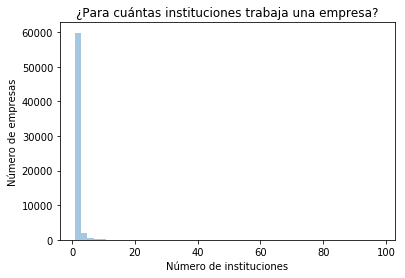

In [5]:
ax = sns.distplot(empresas['count'], kde=False)
ax.set_title("¿Para cuántas instituciones trabaja una empresa?")
ax.set_ylabel("Número de empresas")
ax.set_xlabel("Número de instituciones")
plt.show()

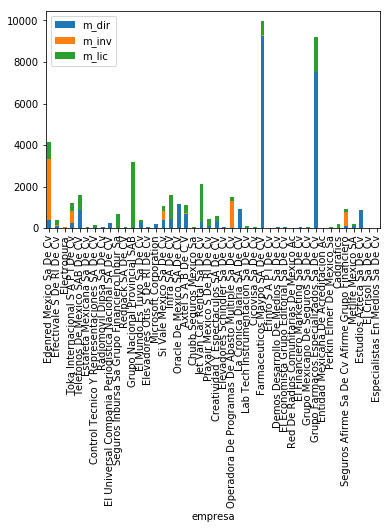

In [6]:
empresas.sort_values('count', ascending=False) \
    .loc[empresas['count']>=25, ['m_dir','m_inv', 'm_lic']] \
    .plot.bar(stacked=True)

In [7]:
institucion = red.groupby("institucion").aggregate({'institucion':{'count':'count'}, 'c_num':{'c_num':'sum'},
                                                    'm_tot':{'sum':'sum', 'mean':'mean', 'max':'max', 'min':'min', 'std':'std'},
                                                    'm_dir':{'m_dir':'sum','p_dir':'sum'},
                                                    'm_inv':{'m_inv':'sum','p_inv':'sum'},
                                                    'm_lic':{'m_lic':'sum','p_lic':'sum'}
                                                   })
institucion.columns = institucion.columns.droplevel()
institucion = institucion.sort_values('count', ascending=False)
institucion[['p_dir','p_inv','p_lic']] = institucion[['p_dir','p_inv','p_lic']].divide(institucion['sum'], axis=0)
institucion[institucion['count']>=100]

/home/esther/.local/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,count,c_num,sum,mean,max,min,std,m_dir,p_dir,m_inv,p_inv,m_lic,p_lic
institucion,,,,,,,,,,,,,
Instituto Mexicano Del Seguro Social,3814,13982,116276.033126,30.486637,19384.823703,0.000000,499.588204,27899.641243,0.239943,3423.600271,0.029444,84952.791612,0.730613
Instituto De Seguridad Y Servicios Sociales De Los Trabajadores Del Estado,3547,9188,35047.269457,9.880820,3729.481714,0.000000,126.357724,16294.765840,0.464937,2179.341834,0.062183,16573.131783,0.472879
Secretaria De Comunicaciones Y Transportes,3295,5615,60898.263012,18.482022,9639.916013,0.000000,222.767886,1876.852352,0.030819,11316.818551,0.185832,47704.093482,0.783341
Secretaria De Cultura,2066,2326,1608.652123,0.778631,266.567088,0.000000,8.391906,830.937739,0.516543,151.759857,0.094340,625.954526,0.389117
Secretaria De Agricultura Y Desarrollo Rural,2026,2374,1161.754509,0.573423,186.048129,0.000000,6.366672,500.637716,0.430932,179.010958,0.154087,482.105835,0.414981
...,...,...,...,...,...,...,...,...,...,...,...,...,...
HgoSecretaria De Contraloria,102,113,12.697166,0.124482,1.213873,0.006034,0.209108,9.301986,0.732603,3.395180,0.267397,0.000000,0.000000
ChihInstituto Chihuahuense De Infraestructura Fisica Educativa,101,333,504.178243,4.991864,112.042206,0.017233,12.159993,193.235209,0.383268,23.851223,0.047307,287.091811,0.569425
Instituto Nacional Del Suelo Sustentable,101,132,64.808172,0.641665,15.828340,0.030327,1.855762,45.356558,0.699859,19.451614,0.300141,0.000000,0.000000


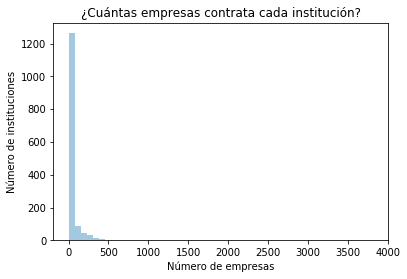

In [8]:
ax = sns.distplot(institucion['count'], kde=False)
ax.set_title("¿Cuántas empresas contrata cada institución?")
ax.set_xlabel("Número de empresas")
ax.set_ylabel("Número de instituciones")
plt.show()


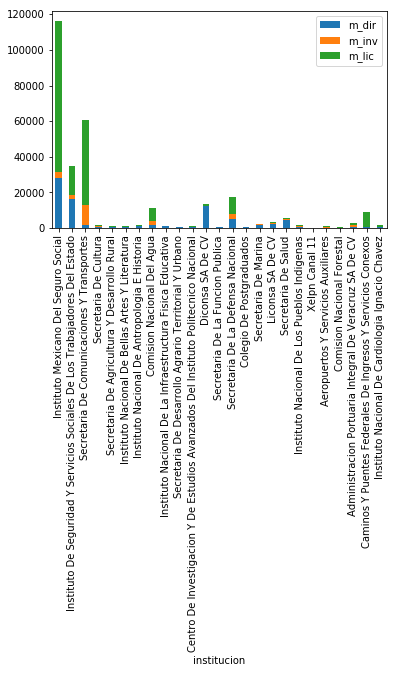

In [9]:
institucion.sort_values('count', ascending=False) \
           .loc[institucion['count']>=500, ['m_dir','m_inv', 'm_lic']] \
           .plot.bar(stacked=True)

Empresas con un solo contrato (esto puede generar errores cuando el problema es nombre incompatible)

In [10]:
singletons = red.groupby('empresa').aggregate({'c_num':'sum'})
singletons = singletons[singletons['c_num']==1].index
print(len(singletons))

40929


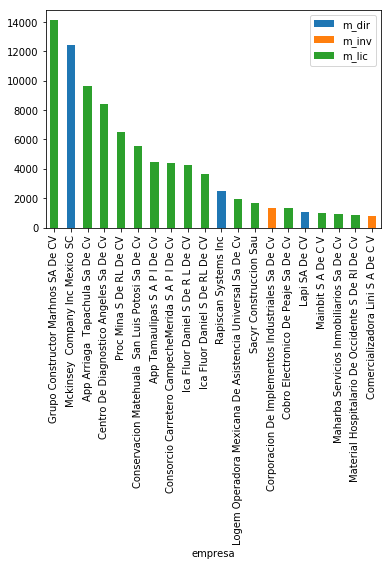

In [11]:
red[red['empresa'].isin(singletons)].sort_values('m_tot', ascending=False) \
           .loc[red['m_tot']>=750, :] \
           .set_index('empresa') \
           .loc[:,['m_dir','m_inv', 'm_lic']] \
           .plot.bar(stacked=True)

Las favoritas

In [13]:
thr_count = 3
thr_tipo = 0.213654
interes = 30
favoritas = empresas[(empresas['count']<=thr_count) & (empresas['p_lic']<=thr_tipo)].sort_values('sum', ascending=False)
print('Favoritas', favoritas.shape[0])
favoritas.head(interes)

Favoritas 52782


,count,c_num,sum,mean,max,min,std,m_dir,p_dir,m_inv,p_inv,m_lic,p_lic
empresa,,,,,,,,,,,,,
Mckinsey Company Inc Mexico SC,1,1,12399.996552,12399.996552,12399.996552,12399.996552,NaN,12399.996552,1.000000,0.000000,0.000000,0.000000,0.000000
Rapiscan Systems Inc,1,1,2474.999688,2474.999688,2474.999688,2474.999688,NaN,2474.999688,1.000000,0.000000,0.000000,0.000000,0.000000
Construcciones E Inmobiliarias Canaro Sa De Cv,1,4,1711.992755,1711.992755,1711.992755,1711.992755,NaN,0.000000,0.000000,1711.992755,1.000000,0.000000,0.000000
Grupo Laboratorios Imperiales Pharma Sa De Cv,3,16,1431.322380,477.107460,686.179063,282.172600,202.373890,1431.322380,1.000000,0.000000,0.000000,0.000000,0.000000
Corporacion De Implementos Industriales Sa De Cv,1,1,1323.363162,1323.363162,1323.363162,1323.363162,NaN,0.000000,0.000000,1323.363162,1.000000,0.000000,0.000000
Lapi SA De CV,1,1,1047.041821,1047.041821,1047.041821,1047.041821,NaN,1047.041821,1.000000,0.000000,0.000000,0.000000,0.000000
Suministrador De Vacunas SA De CV,1,3,1018.929390,1018.929390,1018.929390,1018.929390,NaN,1018.929390,1.000000,0.000000,0.000000,0.000000,0.000000
Grupo Borsen Sa De Cv,1,2,996.361248,996.361248,996.361248,996.361248,NaN,8.748683,0.008781,987.612565,0.991219,0.000000,0.000000
Siglo Xxi Editores Sa De Cv,3,7,974.922683,324.974228,973.883683,0.199000,561.972164,974.922683,1.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
red.loc[red['empresa'].isin(favoritas.head(interes).index),:].groupby(['empresa','institucion']).aggregate('sum')

c_num  \
empresa                                            institucion                                                 
AlCo Salud Inteligente Sa De Cv                    Instituto Mexicano Del Seguro Social                   10   
Canapat Camara Nacional Del Autotransporte De P... Secretaria De La Defensa Nacional                       1   
Comercializadora Arvien Sa De Cv                   Instituto De Seguridad Y Servicios Sociales De ...      4   
                                                   Instituto Mexicano Del Seguro Social                  112   
Comercializadora Lini S A De C V                   Secretaria De La Defensa Nacional                       1   
Comercializadora Pepsico Mexico S De RL De CV      Diconsa SA De CV                                     1287   
Consorcio Empresarial Adper Sa De Cv               Centro Nacional De Control De Energia                   1   
                                                   Secretaria De Relaciones Exteriores                     1   
Construcciones E Inmobiliarias Canaro Sa De Cv     SlpPresidencia Municipal De Tampamolon Corona           4   
Corporacion De Implementos Industriales Sa De Cv   Instituto Nacional De Ciencias Medicas Y Nutric...      1   
Ecc Construcciones Sa De Cv                        Secretaria De Comunicaciones Y Transportes              1   
                                                   TabInstituto Tabasqueno De La Infraestructura F...      1   
Fruitex De Mexico SAPI De CV                       Diconsa SA De CV                                       27   
Gonet Mexico SA De CV                              Banco Del Ahorro Nacional Y Servicios Financier...      1   
Grupo Borsen Sa De Cv                              CdmxSecretaria De Obras Y Servicios                     2   
Grupo Farmacos Especializados S A De C V           Instituto Nacional De Cardiologia Ignacio Chavez        1   
                                                   Instituto Nacional De Enfermedades Respiratorias        5   
                                                   Secretaria De La Defensa Nacional                       7   
Grupo Laboratorios Imperiales Pharma Sa De Cv      Instituto De Seguridad Y Servicios Sociales De ...      5   
                                                   Instituto Mexicano Del Seguro Social                    4   
                                                   Secretaria De Salud                                     7   
Juntos A Nutrir SA De CV                           Diconsa SA De CV                                       27   
Lapi SA De CV                                      Nacional Financiera SNC                                 1   
Marcas Nestle SA De CV                             Diconsa SA De CV                                     1537   
                                                   Instituto Nacional De Cardiologia Ignacio Chavez        1   
                                                   Instituto Nacional De Pediatria                         1   
Mckinsey  Company Inc Mexico SC                    Pronosticos Para La Asistencia Publica                  1   
Medicamentos Y Servicios Integrales Del Noroest... Instituto Mexicano Del Seguro Social                  300   
Molinos Azteca Sa De Cv                            Diconsa SA De CV                                     1851   
Novell De Mexico Sa De Cv                          Secretaria De Gobernacion                               1   
                                                   Secretaria De La Defensa Nacional                       1   
                                                   Servicio De Administracion Tributaria                   2   
Operadora De Programas De Abasto Multiple SA De CV Autoridad Educativa Federal En La Ciudad De Mexico      1   
                                                   Consejo De Promocion Turistica De Mexico SA De CV       1   
                                                   Telecomunicaciones D

Son las mismas empresas populares a lo largo del tiempo

In [12]:
thr = 5
años_venn = [7,8,9]
sets = {}
for t in años_venn:
    df_ = df.loc[df['fecha'].dt.month==t,:]
    df_ = df_.groupby('empresa').aggregate({'institucion':{'inst':lambda x: x.nunique(),'c_num':'count'},
                                            'monto':'sum','direct':'sum','open':'sum','limited':'sum'})
    
    df_.columns = df_.columns.droplevel()
    df_ = df_.reset_index()
    df_ = df_.loc[df_['inst']>=thr,:].sort_values('inst', ascending=False)
    sets[t] = set(df_['empresa'].to_list())
matplotlib_venn.venn3(sets.values(), set_labels=sets.keys())
plt.show()
sets

KeyError: 'fecha'

Quitar las empresas con un solo contrato

red = red[~red['empresa'].isin(singletons)]
print(red.shape)

Volver red

t_red = ['institucion', 'empresa']

G = nx.Graph()
G.add_nodes_from(red[t_red[0]].unique().tolist(), bipartite=0)
G.add_nodes_from(red[t_red[1]].unique().tolist(), bipartite=1)

for index, row in red.iterrows():
    s, t = row[t_red[0]], row[t_red[1]]
    G.add_edge(s,t)
    for i in red.columns[3:]:
        G.edges[s,t][i] = row[i]

len(G.nodes()), len(G.edges())